---
title: "Network charts"
description: "Scrape play-by-play data and analyze line combinations with network graphs"
author: "chicken"
date: "12/31/2025"
categories:
    - "tutorials"
image: charts/nsh_network_graph.png
lightbox: true
draft: false
---

## **Intro**

Use the `chickenstats` library to scrape play-by-play data, aggregate statistics, 
and generate network graphs for forward line combinations

Parts of this tutorial are optional and will be clearly marked as such. For help, or any questions,
please don't hesitate to reach out to [chicken@chickenandstats.com](mailto:chicken@chickenandstats.com) or
[@chickenandstats.com](https://bsky.app/profile/chickenandstats.com) on Blue Sky.

---

![](./charts/nsh_network_graph.png)

---

## **Housekeeping**

### Import dependencies

Import the dependencies we'll need for the guide

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import networkx
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from chickenstats.chicken_nhl import Scraper, Season
from chickenstats.chicken_nhl._helpers import charts_directory
from chickenstats.chicken_nhl.team import NHL_COLORS

### Pandas options

Sets different pandas options. This cell is optional

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

### Folder structure

In [ ]:
charts_directory()

### Chickenstats matplotlib style

chickenstats.utilities includes a custom style package - this activates it. This cell is also optional

In [ ]:
plt.style.use("chickenstats")

---

## **Scrape data**

### Schedule, standings, and team names

Scrape the schedule and standings using the `Season` object. Then, create some name dictionaries for convenience later

In [ ]:
season = Season(2025, backend="pandas")

In [ ]:
schedule = season.schedule()  # Progress bar renders poorly in ipynb to md conversions

Output()

In [ ]:
standings = season.standings  # Standings as a dataframe for the team name dictionaries

In [ ]:
team_names = standings.sort_values(by="team_name").team_name.str.upper().tolist()
team_codes = standings.sort_values(by="team_name").team.str.upper().tolist()
team_names_dict = dict(zip(team_codes, team_names, strict=False))  # These are helpful for later

### Game IDs

Select the team and games to plot. The default are all of the most recent season's games 
for the Nashville Predators :). Feel free to change for your chosen team code 

In [ ]:
team = "NSH"

In [ ]:
conditions = np.logical_and(
    np.logical_or(schedule.home_team == team, schedule.away_team == team), schedule.game_state == "OFF"
)

game_ids = schedule.loc[conditions].game_id.tolist()
latest_date = schedule.loc[conditions].game_date.max()

### Play-by-play

Scrape the play-by-play data for the chosen game ID. First instantiate the `Scraper` object,
then call the play_by_play attribute

In [ ]:
scraper = Scraper(game_ids, backend="pandas")

In [ ]:
pbp = scraper.play_by_play.copy(deep=True)

Output()

### Stats

Aggregate individual statistics after scraping the play-by-play data

In [ ]:
scraper.prep_stats(level="season", teammates=True, disable_progress_bar=True)

In [ ]:
stats = scraper.stats.copy(deep=True)

---

## **Plotting network data**

### Helper functions

Create and draw the network graphs in a convenient plotting function

In [ ]:
def create_network_graph(data: pd.DataFrame, team: str, strengths: list, toi_min: float) -> nx.Graph:
    """Creates a network for a given team and strength state, with time-on-ice as the weight.

    Parameters:
        data (pd.DataFrame):
            Pandas dataframe of individual statistics, aggregated from play-by-play
            data scraped with chickenstats package
        team (str):
            Three-letter team code which determines the coloring used for the chart
        strengths (list):
            List of strength states to aggregate for data
    """
    conds = np.logical_and.reduce(
        [
            data.team == team,
            data.strength_state.isin(strengths),
            data.toi >= toi_min,
            data.position.isin(["C", "L", "R", "L/R", "L/C", "R/L", "R/C", "C/L", "C/R"]),
        ]
    )

    df = data.loc[conds].reset_index(drop=True)

    players = df.player.sort_values().unique().tolist()

    concat_list = [df.player.copy(deep=True)]

    for player in players:
        conds = [
            df.player == player,
            np.logical_and(
                df.player != player, np.logical_or(df.forwards.str.contains(player), df.defense.str.contains(player))
            ),
        ]

        values = [np.nan, df.toi]

        player_series = pd.Series(np.select(conds, values, 0), name=player)

        concat_list.append(player_series)

    df = pd.concat(concat_list, axis=1).groupby("player", as_index=False).sum()

    df = df.set_index("player", drop=True)

    df = (df - df.min().min()) / (df.max().max() - df.min().min()) * 75

    df = df.reset_index()

    df = df.melt(
        id_vars=["player"], value_vars=[x for x in df.columns if x != "player"], var_name="target", value_name="weight"
    ).rename(columns={"player": "source"})

    network_graph = nx.from_pandas_edgelist(df, edge_attr=True)

    return network_graph

In [ ]:
# Helper function to draw any graph
def draw_graph(g: nx.Graph, team: str, edge_options: dict, edge_labels: dict | None = None) -> plt.Figure:
    """Draws the graph G with the specified node and edge options.

    Parameters:
        g (networkx.Graph):
            The graph to be drawn.
        team (str):
            Team code for colors.
        edge_options (dict):
            Options for drawing edges.
        edge_labels (dict, optional):
            Labels for the edges. Defaults to None.
    """
    fig, ax = plt.subplots(dpi=650, figsize=(8, 5))

    # Global color properties
    node_options = {
        "node_color": NHL_COLORS[team]["GOAL"],
        "node_size": 1000,
        "edgecolors": NHL_COLORS[team]["SHOT"],
        "linewidths": 2,
    }

    # Define the layout of the graph
    pos = nx.spring_layout(g, iterations=10, seed=20000)

    # Draw the nodes with the specified options
    nx.draw_networkx_nodes(g, pos, **node_options)

    # Draw the node labels with specified font properties
    nx.draw_networkx_labels(
        g,
        pos,
        font_size=8,
        font_color=NHL_COLORS[team]["SHOT"],
        font_weight="bold",
        bbox={"alpha": 0.5, "color": "white"},
    )

    # Draw the edges with the specified options
    nx.draw_networkx_edges(g, pos, **edge_options)

    # Draw edge labels if they are provided
    if edge_labels:
        nx.draw_networkx_edge_labels(
            g,
            pos,
            edge_labels=edge_labels,
            connectionstyle="arc3, rad=0.3",
            font_size=12,
            font_color=NHL_COLORS[team]["MISS"],
            bbox={"alpha": 0.5, "color": "white"},
        )

    sns.despine(left=True, bottom=True)

    return fig

In [ ]:
def plot_network(stats: pd.DataFrame, team: str, strengths: list, toi_min: float, edge_labels=None):
    """This function plots and saves the actual matplotlib figures.

    Parameters:
        stats (pd.DataFrame):
            Pandas dataframe of individual statistics, aggregated from play-by-play
            data scraped with chickenstats package
        team (str):
            Three-letter team code which determines the coloring used for the chart
        strengths (list):
            List of strength states to plot and pass to the network graph function
        edge_labels (dict, optional):
            Labels for the edges
    """
    g = create_network_graph(data=stats, team=team, strengths=strengths, toi_min=toi_min)

    weights = nx.get_edge_attributes(g, "weight")

    edge_options = {
        "edge_color": NHL_COLORS[team]["SHOT"],
        #'width': 2.5,
        "alpha": 0.7,
        "width": [weights[edge] / 10 for edge in g.edges()],
    }

    fig = draw_graph(g=g, edge_options=edge_options, team=team, edge_labels=edge_labels)

    fig_suptitle = f"{team_names_dict[team].title()} forward line combinations at 5v5"
    fig.suptitle(fig_suptitle, x=0.01, y=1.08, fontsize=11, fontweight="bold", horizontalalignment="left")

    subtitle = f"Width of connecting line indicates time-on-ice | 2025-26 season, as of {latest_date}"
    fig.text(s=subtitle, x=0.01, y=1.02, fontsize=10, horizontalalignment="left")

    # Attribution
    attribution = "Data & xG model @chickenandstats.com | Viz @chickenandstats.com"
    fig.text(s=attribution, x=0.99, y=-0.05, fontsize=8, horizontalalignment="right", style="italic")

    # Save figure
    save_path = Path(f"./charts/{team.lower()}_network_graph.png")
    fig.savefig(save_path, transparent=False, bbox_inches="tight")

---

## **Plotting the data**

### NSH network chart

Plot the network chart with the cell below

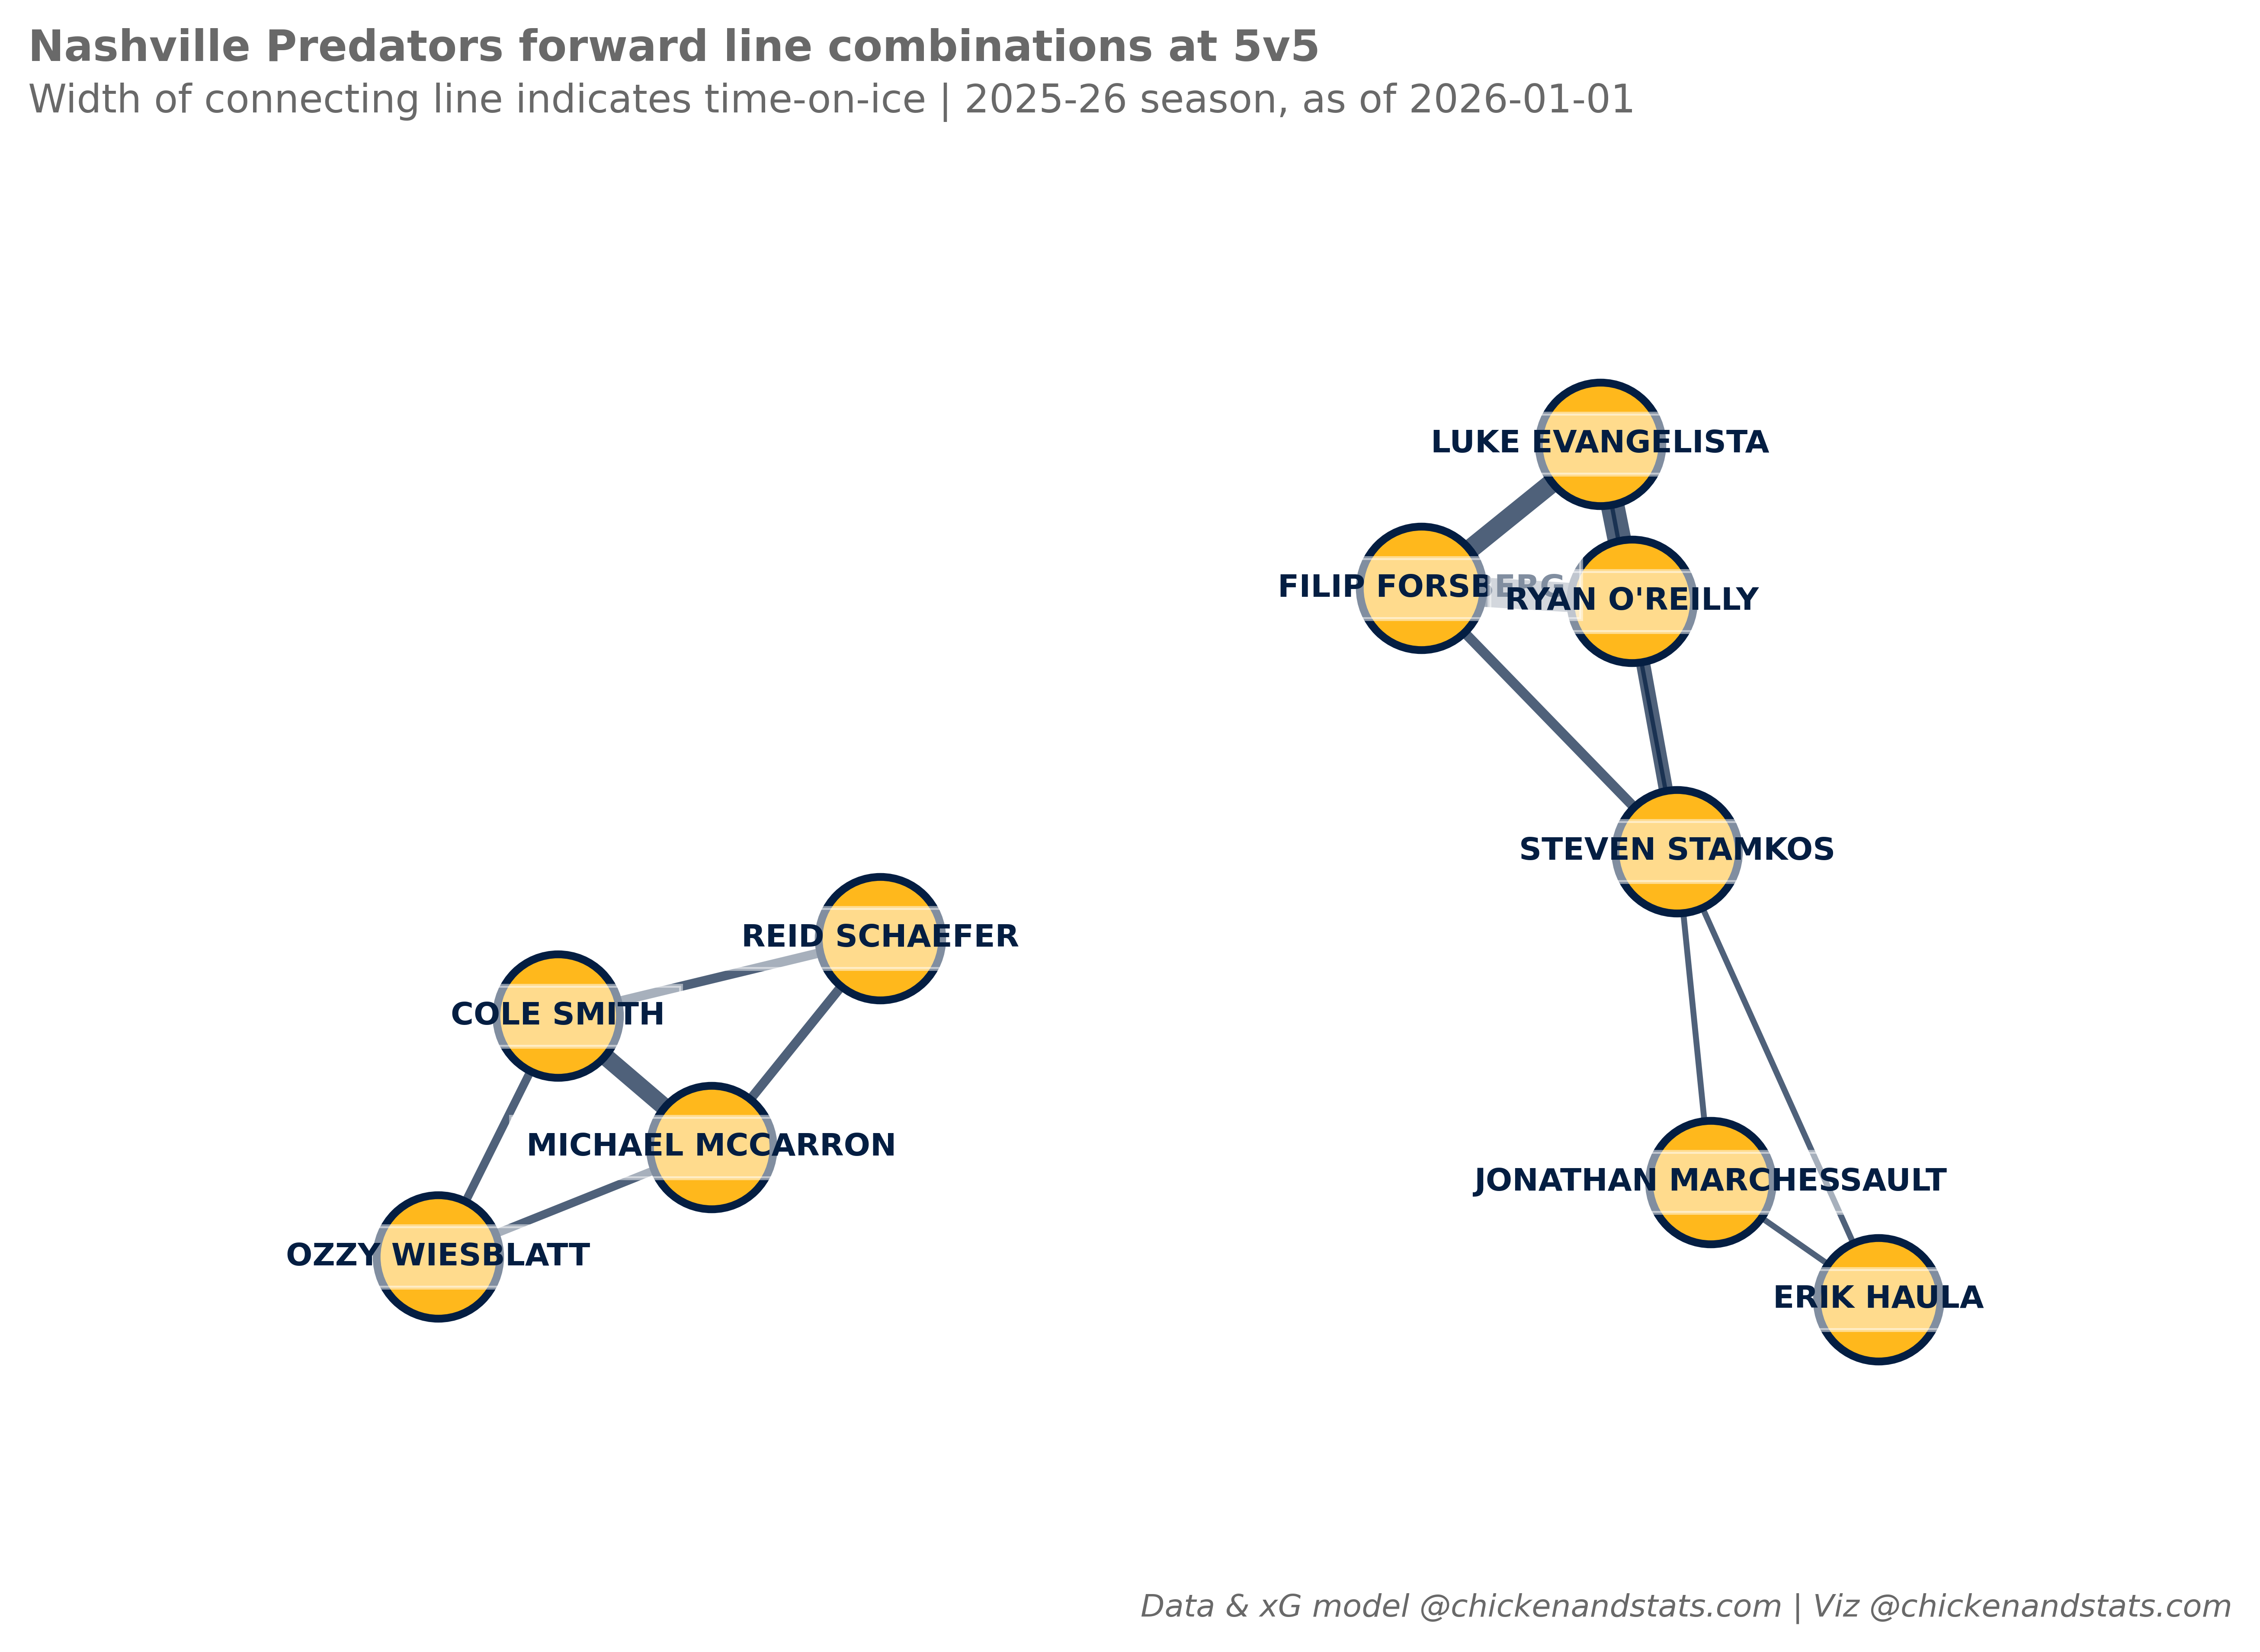

In [ ]:
plot_network(stats=stats, team=team, strengths=["5v5"], toi_min=15.0)